### Feature Selection

When building a predictive model, we often have many features or variable in our dataset that can be used to train our model. However, just because the feature exists in our dataset does not mean that it is relevant for our model or that we should use it.

How do we know which features to use in our model?

This is where feature selection comes in. Feature selection is simply a process that reduces the number of input variables, in order to keep only the most important ones.

There is an advantage in reducing the number of input features, as it simplifies the model, reduces the computation cost, and it can also improve the model’s performance.

Now, how do we decide which feature is important? What does it mean for a feature to be important?

There is no clear answer for that, so we need to experiment with different methods and see which gives the best results.

In this article, we are going to explore and implement three different feature selection methods:

* variance threshold
* K best features
* recursive feature elimination (RFE)

### Getting the data

We will use the wine dataset available on sklearn.

The dataset contains 178 rows with 13 features and a target containing three unique categories. This is therefore a classification task.

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine

wine_data = load_wine()

wine_df = pd.DataFrame(
    data=wine_data.data,
    columns=wine_data.feature_names)

wine_df['target'] = wine_data.target

In [19]:
wine_df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


### Splitting the data
Before implementing feature selection techniques, we first split our data into a training and test set.

That way, we have fixed starting points and a fixed test set so that we can compare the impact of each feature selection method on the model’s performance.

In [20]:
from sklearn.model_selection import train_test_split

X = wine_df.drop(['target'], axis=1)
y = wine_df['target']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=42)

With this split, we have 124 samples for the training set, and 54 samples for the test set. Note the use of stratify, which ensures that both the train and test sets contain the same proportion of the target class.

### Selecting the best features
We now dive into the feature selection methods. As mentioned above we will try three different methods and see how it impacts the model’s performance.

To make this experiment robust, we will use a simple decision tree classifier.

### Variance threshold
The first method we will explore is the variance threshold. This is, of course, based on the variance, which is a measure of dispersion. In other words, **it measures how far a set of number is spread out from their average value.**

For example, the variance of [1, 1, 1, 1, 1] is 0, because each number is equal to their average value. Therefore, they do not spread out from their mean value.

Variance threshold then simply removes any feature with a variance that is below a given threshold.

We can see how this is useful to remove features with a variance close to 0, because this means that the values are constant or vary only slightly across all samples of the dataset. Therefore, they do not have any predictive power.

Thus, let’s compare the variance of each feature in our training set.

In [21]:
X_train_v1 = X_train.copy()
X_train_v1.var(axis=0)

alcohol                             0.658341
malic_acid                          1.123507
ash                                 0.072433
alcalinity_of_ash                  11.471279
magnesium                         232.071532
total_phenols                       0.393226
flavanoids                          0.912299
nonflavanoid_phenols                0.013873
proanthocyanins                     0.335108
color_intensity                     5.669722
hue                                 0.052891
od280/od315_of_diluted_wines        0.470021
proline                         94906.710923
dtype: float64

 We can see that the variance for each of the features of the training set. However, we cannot define a variance threshold just yet, because our data does not have the same scale, and so the variance is not on the same scale either.

Data on a larger scale can have a higher variance than features on a smaller scale, even if their distribution is similar.

Thus, it is important to first scale our data before defining a threshold. Here, we normalize the data and then calculate the variance.

In [22]:
from sklearn.preprocessing import Normalizer

norm = Normalizer().fit(X_train_v1)
norm_X_train = norm.transform(X_train_v1)
norm_X_train.var(axis=0)

array([4.91904873e-05, 6.21699082e-06, 1.84444433e-06, 2.09448705e-04,
       2.68754975e-03, 2.30121336e-06, 2.94585256e-06, 9.07454007e-08,
       1.52283266e-06, 1.56043625e-05, 5.25705889e-07, 3.50720354e-06,
       8.83697816e-05])

We can now see that the variance of each scaled feature. While the variance is very small for all, some feature have incredibly small variance, with power to -8 and to -7.

Thus, let’s set our threshold to 1e-6. Any feature with a variance below that threshold will be removed.

In [23]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold = 1e-6)
selected_features = selector.fit_transform(norm_X_train)
selected_features.shape

(124, 11)

We can now see how a decision tree classifier performs when using all the features available, and we remove the two features mentioned above.

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

dt = DecisionTreeClassifier(random_state=42)

#Classifier with all features
dt.fit(X_train, y_train)
preds = dt.predict(X_test)
f1_score_all = round(f1_score(y_test, preds, average='weighted'),3)

# Classifier with selected features with variance threshold
X_train_sel = X_train.drop(['hue', 'nonflavanoid_phenols'], axis=1)
X_test_sel = X_test.drop(['hue', 'nonflavanoid_phenols'], axis=1)

dt.fit(X_train_sel, y_train)

preds_sel = dt.predict(X_test_sel)
f1_score_sel = round(f1_score(y_test, preds_sel, average='weighted'), 3)

Printing the F1-score for both models gives 0.963. Thus, removing two features did not improve the model, but we do achieve the same performance.

Therefore, a simpler model with fewer features achieved the same result as using all features, which is a good sign.

Now, using variance threshold is somewhat simple, and setting the threshold is somewhat arbitrary.

With the next method, we can easily find the optimal number of variables to keep while deciding the selection criteria.

### K best features
Here, we use a method that gives more flexibility in evaluating the importance of a feature.

The algorithm is simple: we simply provide a method of calculating the importance of a feature and the number of features we want to use, denoted as k. Then, the algorithm simply returns the top k features.

The main advantage of this method is that we are free to choose among a variety of ways to compute the importance of a feature. For example, we can use the chi squared test to quantify the independence of a feature to a the target. The higher the score, the higher the dependency between the feature and the target, and so the higher the importance of that feature.

Other methods can be used, such as computing the mutual information, using the False Positive Rate test, or calculating the F-statistic for a regression task.

Now, we still have the challenge of determining how many variables should be selected for the model. Here, since we are working with only 13 features in total, let’s try using one to all features and see which configuration gives us the best results.

Here, we use the chi squared test, as we are working with a classification task.

In [25]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_train_v2, X_test_v2, y_train_v2, y_test_v2 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()
f1_score_list = []

for k in range(1, 14):
    selector = SelectKBest(chi2, k=k)
    selector.fit(X_train_v2, y_train_v2)

    sel_X_train_v2 = selector.transform(X_train_v2)
    sel_X_test_v2 = selector.transform(X_test_v2)

    dt.fit(sel_X_train_v2, y_train_v2)
    kbest_preds = dt.predict(sel_X_test_v2)

f1_score_kbest = round(f1_score(y_test, kbest_preds, average='weighted'), 3)
f1_score_list.append(f1_score_kbest)

print(f1_score_list)

[0.963]


We can now plot the F1-score for each number of variables used in the model:

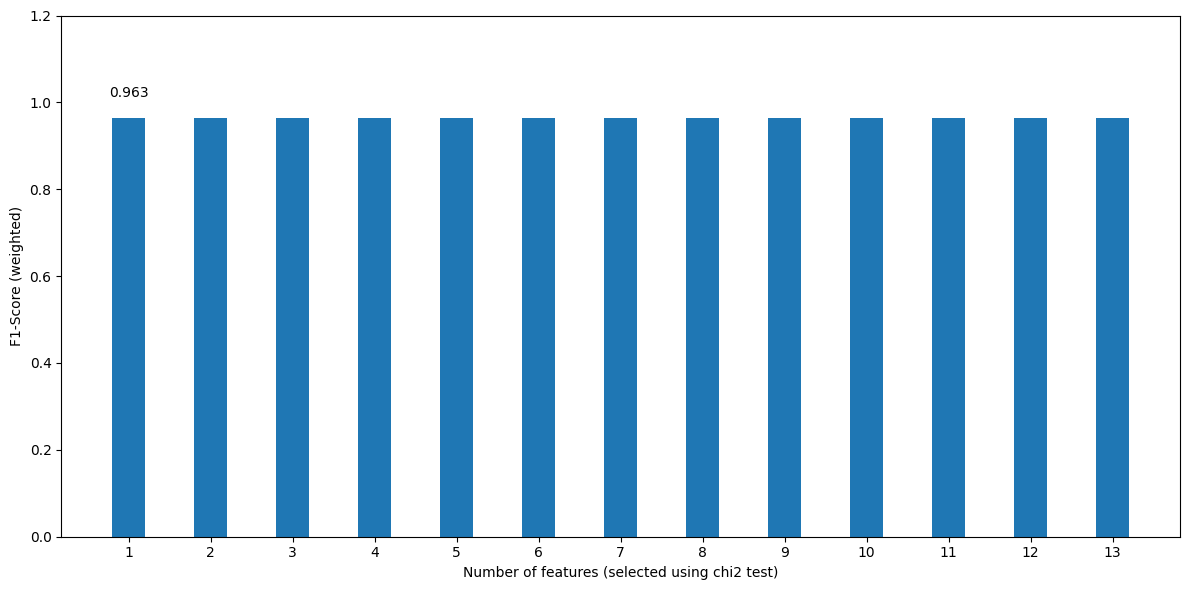

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))

x = ['1','2','3','4','5','6','7','8','9','10','11','12','13']
y = f1_score_list

ax.bar(x, y, width=0.4)
ax.set_xlabel('Number of features (selected using chi2 test)')
ax.set_ylabel('F1-Score (weighted)')
ax.set_ylim(0, 1.2)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(value), ha='center')

plt.tight_layout()

Looking at the figure above, we see that using only the most important feature, according to the chi squared test, gives us the worst performance, while using the top 11 features results in a perfect F1-score. However, let’s also notice that using the top 6 features gives an F1-score of 0.981, which is a small drawback considering that we are using half of the features. Plus, we see a similar performance using only the top 4 features.

With this example, we can clearly see how feature selection can only simplify the model, but also increase its performance, even if we are working with a simple toy dataset.

Of course, using a different evaluator of the feature importance might lead to different results. I invite you to use another test than the chi squared test, and see for yourself if the resulting plot changes drastically.

Let’s move on to the last method we will implement: Recursive Feature Elimination or RFE.

### Recursive Feature Elimination (RFE)

The last method we implement in this article is Recursive Feature Elimination or RFE.

What is interesting about this feature selection method, is that it relies on the model’s capacity to evaluate the importance of a feature. Therefore, we must use a model that returns either a coefficient or a measure of feature importance.

Here, since we are using a decision tree, the model can actually calculate the importance of a feature.

In a decision tree, the importance of a feature is calculated as the decrease in node impurity multiplied by the probability of reaching that node. This is based on the CART algorithm that runs behind the scenes of a decision tree.

Now, let’s test the RFE selection method. We will set the number of input variables to 4, and see how the performance compares to selecting the top 4 features using the chi squared test. That way, we will see which method of evaluating feature importance (chi squared test or feature importance as computed by the decision tree) can choose the best four features for our model.

Implementing RFE is very straightforward using sklearn. First, we define the selector and specify the number of features we want. In this case, we want four. Then, we fit the selector on the training set, which will return us the top 4 features.



In [15]:
from sklearn.feature_selection import RFE

X_train_v3, X_test_v3, y_train_v3, y_test_v3 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

RFE_selector = RFE(estimator=dt, n_features_to_select=4, step=1)

RFE_selector.fit(X_train_v3, y_train_v3)

RFE(estimator=DecisionTreeClassifier(random_state=42), n_features_to_select=4)

We can also see the name of the selected features by accessing the support_ attribute.

In [16]:
X_train_v3.columns[RFE_selector.support_]

Index(['alcalinity_of_ash', 'flavanoids', 'color_intensity', 'proline'], dtype='object')

Here, we see that the top 4 features are:

* alcalinity_of_ash
* flavanoids
* color_intensity
* proline

Now, we can fit the model using only those top 4 features and calculate the F1-score on the test set.

In [17]:
sel_X_train_v3 = RFE_selector.transform(X_train_v3)
sel_X_test_v3 = RFE_selector.transform(X_test_v3)

dt.fit(sel_X_train_v3, y_train_v3)

RFE_preds = dt.predict(sel_X_test_v3)

rfe_f1_score = round(f1_score(y_test_v3, RFE_preds, average='weighted'),3)
print(rfe_f1_score)


0.944


### Conclusion

We explored and implemented three different feature selection methods:

* variance threshold
* K best features
* recursive feature elimination (RFE)

Variance threshold is good to remove features that have 0 variance, as a constant variable is definitely not a good variable. However, setting a variance threshold is hard and quite arbitrary, and I suggest using it along K best features or RFE.

With K best features, we are able to choose how to evaluate the importance of a feature, which also allows us to determine the best method and the best number of features to include in our model.

Finally, RFE is another feature selection method, that relies on the model itself to compute the importance of a feature.